# Fox News

Because Fox News does not provide an API or any news archives (at least inaccessible to regular users), Selenium is an excellent tool to scrape its web contents. My objective is only to get URLs of related articles so that I can use the newspaper API to extract and store the full text afterwards. Using Selenium requires installing a chromedriver. The code here consists of:
1. Scraping metadata (i.e., headlines, URLs, categories) by looping through various "categories" (e.g., environment, carbon emissions, water pollution)
2. Visualizing distribution of topical relevance via an arbitrarily determined "score"

## Scraping Metadata

In [3]:
import sqlite3
import requests
import re
import newspaper
from newspaper import Article, Source
from sqlalchemy import create_engine
from IPython import display
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
chromedriver = '/Applications/chromedriver'
os.environ['webdriver.chrome.driver'] = chromedriver

import cnfg
from pprint import pprint
import time
import datetime

import pandas as pd
%pylab inline
import seaborn as sns
sns.set()

As a [cateogory page on Fox News](https://www.foxnews.com/category/world/environment) only displays a few headlines with hyperlinks at a time, one must click "Show More" to get more (older) articles. However, clicking "Show More" refreshes the page (chromedriver's perspective), so I used a variable `prev_n_article` to track the total number of articles after each click to avoid getting metadata from the same articles over and over again.

In [ ]:
# open driver
driver = webdriver.Chrome(chromedriver)

# paste new category webpages
driver.get('http://www.foxnews.com/category/us/environment/carbon-emissions.html')

# global params
count = 0
prev_n_article = 1
urls = []

while count < 12000:
    
    # click on SHOW MORE
    ipt = driver.find_element_by_xpath('//*[@id="wrapper"]/div/div[2]/div/main/div/footer/div/a')
    ipt.send_keys(Keys.RETURN)

    # number of articles on screen + 1 (i.e., for 10 articles, loop from article 1 to 10)
    n_articles = len(driver.find_elements_by_xpath('//*[@id="wrapper"]/div/div[2]/div/main/div/div/article')) + 1

    for i in range(prev_n_article, n_articles):
        try:
            article_xpath = '//*[@id="wrapper"]/div/div[2]/div/main/div/div/article[{}]/div[2]/header'.format(i)
            category_xpath = article_xpath + '/div/span[1]/a'
            category = driver.find_element_by_xpath(category_xpath).text
            url_xpath = article_xpath + '/h2/a'
            url = driver.find_element_by_xpath(url_xpath).get_attribute('href')
            hl = driver.find_element_by_xpath(url_xpath).text
            urls.append(dict(zip(['headline', 'url', 'category'], [hl, url, category])))
            count += 1

            # print for debugging
            if count % 50 == 0:
                display.clear_output()
                print(hl, url)

            # save to csv, reset dataframe
            if count % 100 == 0:
                pd.DataFrame(urls).to_csv('foxnews_env.csv', index=False, header=None, mode='a')
                urls = []

            # reassign number of articles to update loop (filter duplicates)
            prev_n_article = n_articles
        
        except:
            continue

In [227]:
pd.DataFrame(urls).to_csv('foxnews_env.csv', index=False, header=None, mode='a')
urls = []

## Checking for Relevance

Using keywords from headlines and categories, we can somewhat estimate the relevance of these articles. Here, I broke down headlines and category names into words and counted the word frequencies. I assigned a "score" to an article by summing these word frequencies together. My assumption is that, due to these articles being previously categorized, articles whose headlines contain the same words likely talk about the same environment-related topic. In addition, if the headline has a "critical" word (e.g., EPA) or if its category is topical (e.g., climate, emissions), I arbitrarily add a bonus 2000 to the relevance score.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [3]:
fox = pd.read_csv('fox_cleaned.csv')

In [85]:
# fast tokenization of headlines and category names using count vectorizer
head = CountVectorizer()
heads = head.fit_transform(fox['headline'])
heads_d = dict(pd.DataFrame(heads.toarray(), columns=sorted(head.vocabulary_.keys())).sum())

cat = CountVectorizer()
cats = cat.fit_transform(fox['category'])
cats_d = dict(pd.DataFrame(cats.toarray(), columns=sorted(cat.vocabulary_.keys())).sum())

d = Counter(cats_d) + Counter(heads_d)

In [109]:
def relevance(row):
    rel = 0
    hl = row['headline'].lower().replace('[^a-z ]', '').split()
    for i in hl:
        if i in d:
            rel += d[i]
        if i in ['epa']:
            rel += 2000
    cat = row['category'].lower().split()
    for j in cat:
        rel += d[j]
        if j in ['climate', 'emissions', 'water']:
            rel += 2000
    return rel

fox['relevance'] = fox.apply(relevance, axis=1)

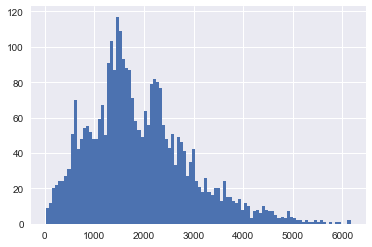

In [110]:
fox['relevance'].hist(bins=100);

There seems to be some separation between articles with a "relevance score" below and those above 2000, as expected (i.e., articles with a score slightly above 2000 contain the keyword or belongs to a category of interest). However,  due to the limited number of articles scraped from Fox News ("Show More" does not necessarily grab all articles in the last decade), I decided not to drop any Fox News articles, and included all of them in the corpus for NLP analysis. Topic modeling results should not be affected drastically, as the low-score articles only account for less than 10% of the entire corpus.